# I. Introduction

The goal of this study is to see the emerging markets in the Retail Shop Datasets through cluster analysis.

# II. Cleaning the Datasets
There are 3 datasets for this study: customers, product categories and transactions. Some columns of the datasets were transformed to lowercase and renamed for easier understanding. Rows with null values were also dropped since they would give no value at all.

At the end of this section, these three are merged into one dataset using SQL syntax enabled by the pandasql library.

In [77]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML 

sns.set(rc={'figure.figsize':(10,10)})

In [106]:
# Load the csv datasets into pandas dataframes
dataset_dir = os.path.join(os.getcwd(), 'dataset')

## A. The Customers Dataset

In [2]:
customer_csv = os.path.join(dataset_dir, 'Customer.csv')
customer_df = pd.read_csv(customer_csv)

In [3]:
customer_df_col_map = {
    'customer_Id': 'customer_id',
    'DOB': 'birth_year',
    'Gender': 'gender'
}
customer_df.rename(columns=customer_df_col_map, inplace=True)

In [5]:
# Check for and drop the rows with null values
customer_df.isna().sum()

customer_id    0
birth_year     0
gender         2
city_code      2
dtype: int64

In [6]:
customer_df.dropna(inplace=True)
customer_df.reset_index(drop=True, inplace=True)

In [7]:
# Transform the former DOB column to Year only
customer_df['birth_year'] = customer_df['birth_year'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').year)

In [8]:
customer_df.head()

,customer_id,birth_year,gender,city_code
0,268408,1970,M,4.0
1,269696,1970,F,8.0
2,268159,1970,F,8.0
3,270181,1970,F,2.0
4,268073,1970,M,1.0


## B. Product Categories Dataset

In [9]:
prodcat_csv = os.path.join(dataset_dir, 'prod_cat_info.csv')
prodcat_df = pd.read_csv(prodcat_csv)

In [11]:
# Rename column prod_subcat to prod_sub_cat for consistency
prodcat_df.rename(columns={'prod_subcat': 'prod_sub_cat'}, inplace=True)

Notice that "prod_cat" column with values "Clothing", "Footwear" and "Bags" all have the same "prod_sub_cat" values. To avoid confusion later on in the clustering, the "prod_sub_cat" values must be unique.

In [107]:
prodcat_df[prodcat_df['prod_cat'].isin(["Clothing", "Footwear", "Bags"])]

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_sub_cat
0,1,Clothing,4,clothing_mens
1,1,Clothing,1,clothing_women
2,1,Clothing,3,clothing_kids
3,2,Footwear,1,footwear_mens
4,2,Footwear,3,footwear_women
5,2,Footwear,4,footwear_kids
11,4,Bags,1,bags_mens
12,4,Bags,4,bags_women


Function rename_prod_sub_cat is created to transform the "prod_sub_cat" values.

In [14]:
def rename_prod_sub_cat(prod_cat_value, old_sub_cat, new_sub_cat):
    # Locate the row that corresponds to parm prod_cat_value and old_sub_cat
    # Replace the prod_sub_cat of that row with the new_sub_cat
    prodcat_df.loc[(prodcat_df['prod_cat'] == prod_cat_value) &
                   (prodcat_df['prod_sub_cat'] == old_sub_cat),
                   'prod_sub_cat'] = new_sub_cat

In [15]:
rename_prod_sub_cat('Clothing', 'Mens', 'clothing_men')
rename_prod_sub_cat('Clothing', 'Women', 'clothing_women')
rename_prod_sub_cat('Clothing', 'Kids', 'clothing_kids')
rename_prod_sub_cat('Footwear', 'Mens', 'footwear_men')
rename_prod_sub_cat('Footwear', 'Women', 'footwear_women')
rename_prod_sub_cat('Footwear', 'Kids', 'footwear_kids')
rename_prod_sub_cat('Bags', 'Mens', 'bags_mens')
rename_prod_sub_cat('Bags', 'Women', 'bags_women')

In [16]:
prodcat_df

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_sub_cat
0,1,Clothing,4,clothing_mens
1,1,Clothing,1,clothing_women
2,1,Clothing,3,clothing_kids
3,2,Footwear,1,footwear_mens
4,2,Footwear,3,footwear_women
5,2,Footwear,4,footwear_kids
6,3,Electronics,4,Mobiles
7,3,Electronics,5,Computers
8,3,Electronics,8,Personal Appliances
9,3,Electronics,9,Cameras


## C. Transactions Dataset

In [109]:
transact_csv = os.path.join(dataset_dir, 'Transactions.csv')
transact_df = pd.read_csv(transact_csv)

In [110]:
# Set to lowercase these columns of transact_df for easier reference
transact_df_col_map = {
    'cust_id': 'customer_id',
    'prod_subcat_code': 'prod_sub_cat_code',
    'Qty': 'qty',
    'Rate': 'rate',
    'Tax': 'tax',
    'Store_type': 'store_type',
    'tran_date': 'transact_date'
}
transact_df.rename(columns=transact_df_col_map, inplace=True)

There are some transactions where the "qty" columns is less than 1. These can be interpreted as returns or refunds. However, since this study aims to know the emerging markets, these refund rows will be dropped. 

In [118]:
transact_df[transact_df['qty'] < 1].head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [20]:
# Remove the rows where qty is less than 1
rows_to_drop = transact_df[transact_df['qty'] < 1].index
transact_df.drop(rows_to_drop, axis=0, inplace=True)
transact_df.reset_index(drop=True, inplace=True)

Convert "transact_date" to a datetime object. This column has a mix of dates formatted in DD-MM-YYYY and DD/MM/YYYY, so pandas.to_datetime with dayfirst=True param is used

In [119]:
transact_df['transact_date'] = pd.to_datetime(transact_df['transact_date'], dayfirst=True)

Create new columns transact_year and transact_month that are derived from transact_date.

In [121]:
transact_df['transact_year'] = transact_df['transact_date'].dt.year
transact_df['transact_month'] = transact_df['transact_date'].dt.month

In [120]:
transact_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop


## D. Merging the Datasets
The library pandasql is used to join the three datasets together using SQL. This is more precise and easier to read, because the SQL Joins allow more control than pandas.

In [24]:
# Use pandasql to easily merge the three datasets together
from pandasql import sqldf

In [25]:
merged_df = lambda query: sqldf(query, globals())
query = """
    SELECT
        t.*,
        c.birth_year,
        c.gender,
        c.city_code,
        p.prod_cat,
        p.prod_sub_cat
    FROM transact_df t
    INNER JOIN customer_df c
        on c.customer_id = t.customer_id
    INNER JOIN prodcat_df p
        ON p.prod_cat_code = t.prod_cat_code
        AND p.prod_sub_cat_code = t.prod_sub_cat_code
"""
merged_df = merged_df(query)

Add new column 'age_at_purchase'

In [28]:
# Add column of age at time of purchase
merged_df['age_at_purchase'] = merged_df['transact_year'] - merged_df['birth_year']

In [122]:
merged_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
0,58387181112,275068,2013-12-31 00:00:00.000000,8,3,5,792,415.800,4375.800,e-Shop,2013,12,1982,M,2.0,Electronics,Personal Appliances,31
1,21300411973,274568,2013-12-31 00:00:00.000000,2,6,1,1054,110.670,1164.670,Flagship store,2013,12,1984,F,9.0,Home and kitchen,Furnishing,29
2,45524941068,268722,2013-12-31 00:00:00.000000,10,5,5,124,65.100,685.100,Flagship store,2013,12,1985,F,5.0,Books,Non-Fiction,28
3,26100869804,273836,2013-12-31 00:00:00.000000,9,3,3,843,265.545,2794.545,e-Shop,2013,12,1983,M,10.0,Electronics,Cameras,30
4,48660589294,274767,2013-12-31 00:00:00.000000,12,5,1,762,80.010,842.010,MBR,2013,12,1981,M,8.0,Books,Academic,32


# Exploring the Data

## The hfdljkafbahef;oiwhf
## dnaksfhksdfh

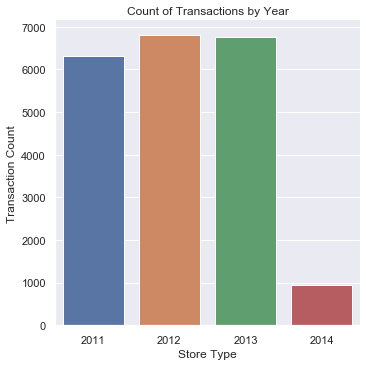

In [30]:
fig = sns.catplot(x='transact_year', kind='count',data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count",title="Count of Transactions by Year")

As the 2014 transactions are up to Feburary only, remove all 2014 transactions from the dataframe.

In [31]:
rows_to_drop = merged_df[merged_df['transact_year'] == 2014].index
merged_df.drop(rows_to_drop, axis=0, inplace=True)
merged_df.reset_index(drop=True,inplace=True)

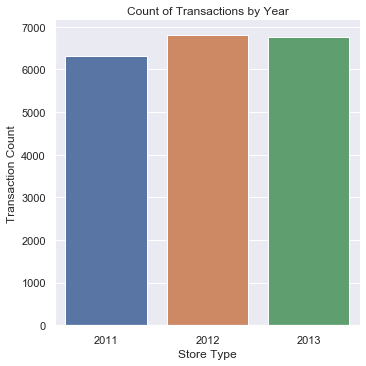

In [32]:
fig = sns.catplot(x='transact_year', kind='count',data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count",title="Count of Transactions by Year")

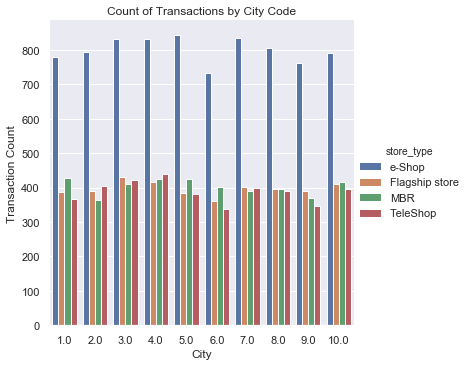

In [33]:
fig = sns.catplot(x='city_code', kind='count', hue='store_type', data=merged_df )
fig.set(xlabel='City', ylabel="Transaction Count",title="Count of Transactions by City Code")

In [ ]:
fig = sns.catplot(x='city_code', kind='count', hue='store_type', data=merged_df )
fig.set(xlabel='City', ylabel="Transaction Count",title="Count of Transactions by City Code")

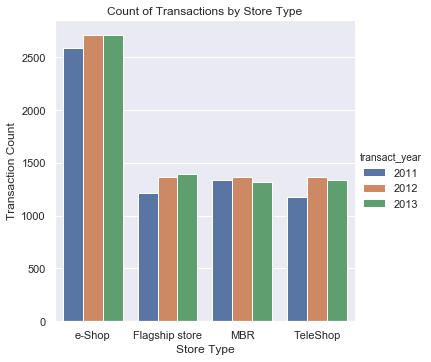

In [105]:
fig = sns.catplot(x='store_type', kind='count', hue='transact_year', data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count",title="Count of Transactions by Store Type")

Text(0.5, 0, 'Store Type')

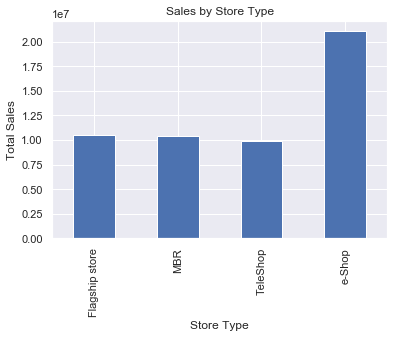

In [35]:
plt = merged_df.groupby('store_type').total_amt.sum().plot(kind='bar')
plt.set_title('Sales by Store Type')
plt.set_ylabel('Total Sales')
plt.set_xlabel('Store Type')

## Focusing on the e-Shop

In [36]:
eshop_df = merged_df.copy(deep=True)
rows_to_drop = eshop_df[eshop_df['store_type'] != 'e-Shop'].index
eshop_df.drop(rows_to_drop, axis=0, inplace=True)
eshop_df.reset_index(drop=True, inplace=True)
eshop_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
0,58387181112,275068,2013-12-31 00:00:00.000000,8,3,5,792,415.800,4375.800,e-Shop,2013,12,1982,M,2.0,Electronics,Personal Appliances,31
1,26100869804,273836,2013-12-31 00:00:00.000000,9,3,3,843,265.545,2794.545,e-Shop,2013,12,1983,M,10.0,Electronics,Cameras,30
2,4116412179,269788,2013-12-31 00:00:00.000000,10,3,3,984,309.960,3261.960,e-Shop,2013,12,1984,F,1.0,Electronics,Audio and video,29
3,51849180620,273963,2013-12-31 00:00:00.000000,9,3,3,617,194.355,2045.355,e-Shop,2013,12,1971,F,7.0,Electronics,Cameras,42
4,73514951834,269518,2013-12-31 00:00:00.000000,6,5,2,582,122.220,1286.220,e-Shop,2013,12,1980,M,2.0,Books,DIY,33


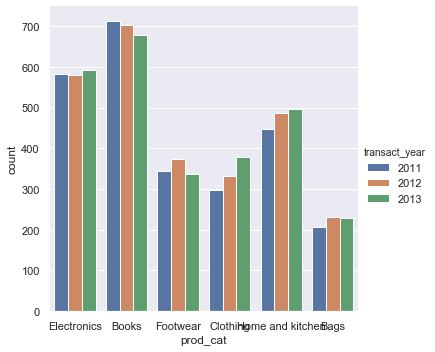

In [37]:
sns.catplot(x='prod_cat', kind='count', hue='transact_year', data=eshop_df)

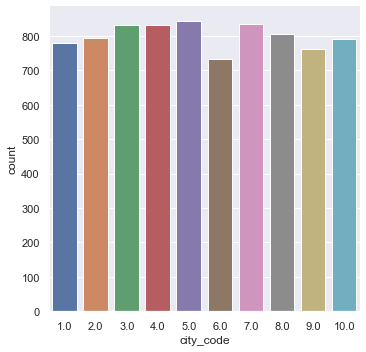

In [38]:
sns.catplot(x='city_code', kind='count', data=eshop_df)

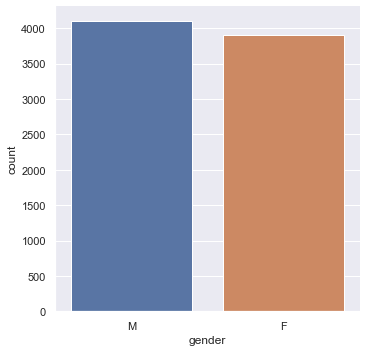

In [39]:
sns.catplot(x='gender', kind='count', data=eshop_df)

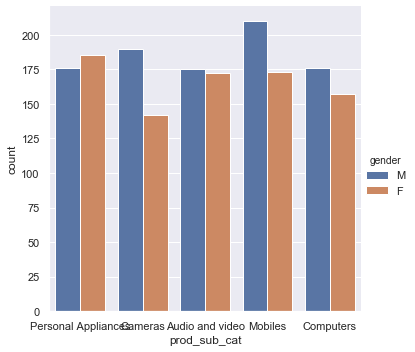

In [40]:
sub_cat_df = eshop_df[eshop_df['prod_cat_code'] == 3]
sns.catplot(x='prod_sub_cat', kind='count', hue='gender', data=sub_cat_df)

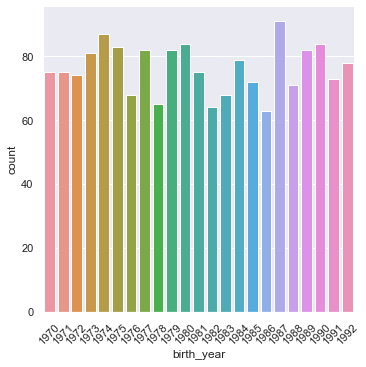

In [41]:
fig = sns.catplot(x='birth_year', kind='count', data=sub_cat_df)
fig.set_xticklabels(rotation=45)

In [42]:
eshop_df.groupby(['customer_id']).size()
eshop_df.customer_id.value_counts()
eshop_df.head

<bound method NDFrame.head of       transaction_id  customer_id               transact_date  \
0        58387181112       275068  2013-12-31 00:00:00.000000   
1        26100869804       273836  2013-12-31 00:00:00.000000   
2         4116412179       269788  2013-12-31 00:00:00.000000   
3        51849180620       273963  2013-12-31 00:00:00.000000   
4        73514951834       269518  2013-12-31 00:00:00.000000   
...              ...          ...                         ...   
8006     49882891062       271982  2011-01-25 00:00:00.000000   
8007     14787475597       273982  2011-01-25 00:00:00.000000   
8008     40893803228       272049  2011-01-25 00:00:00.000000   
8009     94340757522       274550  2011-01-25 00:00:00.000000   
8010     89780862956       270022  2011-01-25 00:00:00.000000   

      prod_sub_cat_code  prod_cat_code  qty  rate      tax  total_amt  \
0                     8              3    5   792  415.800   4375.800   
1                     9              3    3

In [43]:
eshop_count_by_customer = eshop_df.customer_id.value_counts()
eshop_count_by_customer = eshop_count_by_customer[eshop_count_by_customer > 3]
eshop_count_by_customer
repeat_eshop_df = eshop_df[eshop_df['customer_id'].isin(eshop_count_by_customer.index)]
repeat_eshop_df

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
2,4116412179,269788,2013-12-31 00:00:00.000000,10,3,3,984,309.960,3261.960,e-Shop,2013,12,1984,F,1.0,Electronics,Audio and video,29
7,34058748311,272742,2013-12-30 00:00:00.000000,4,2,2,998,209.580,2205.580,e-Shop,2013,12,1989,M,3.0,Footwear,footwear_kids,24
11,51514545410,270709,2013-12-30 00:00:00.000000,1,1,5,1304,684.600,7204.600,e-Shop,2013,12,1976,M,7.0,Clothing,clothing_women,37
12,71147803470,269304,2013-12-30 00:00:00.000000,12,5,1,711,74.655,785.655,e-Shop,2013,12,1987,F,5.0,Books,Academic,26
14,8309911857,267203,2013-12-29 00:00:00.000000,10,3,1,1169,122.745,1291.745,e-Shop,2013,12,1987,M,1.0,Electronics,Audio and video,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,63909639059,269563,2011-01-26 00:00:00.000000,10,6,4,357,149.940,1577.940,e-Shop,2011,1,1975,F,5.0,Home and kitchen,Kitchen,36
7997,83901074423,270550,2011-01-26 00:00:00.000000,3,2,3,474,149.310,1571.310,e-Shop,2011,1,1985,F,8.0,Footwear,footwear_women,26
8001,90114483354,268097,2011-01-26 00:00:00.000000,10,5,4,1408,591.360,6223.360,e-Shop,2011,1,1992,F,7.0,Books,Non-Fiction,19
8003,61812307223,274306,2011-01-25 00:00:00.000000,4,4,4,1447,607.740,6395.740,e-Shop,2011,1,1989,M,2.0,Bags,bags_women,22


In [44]:
repeat_eshop_df.customer_id.value_counts()

270632    6
268145    6
274854    6
269716    6
268025    6
         ..
269449    4
273543    4
273510    4
269388    4
268299    4
Name: customer_id, Length: 335, dtype: int64

In [45]:
repeat_eshop_df[repeat_eshop_df['customer_id'] == 270632]

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
1365,25143689614,270632,2013-06-30 00:00:00.000000,10,6,5,119,62.475,657.475,e-Shop,2013,6,1975,F,9.0,Home and kitchen,Kitchen,38
2385,93447895641,270632,2013-02-12 00:00:00.000000,12,5,5,606,318.150,3348.150,e-Shop,2013,2,1975,F,9.0,Books,Academic,38
4351,97653068469,270632,2012-05-22 00:00:00.000000,10,3,3,1258,396.270,4170.270,e-Shop,2012,5,1975,F,9.0,Electronics,Audio and video,37
5472,99141683489,270632,2011-12-25 00:00:00.000000,3,2,5,1270,666.750,7016.750,e-Shop,2011,12,1975,F,9.0,Footwear,footwear_women,36
5933,33394669025,270632,2011-10-25 00:00:00.000000,5,3,4,495,207.900,2187.900,e-Shop,2011,10,1975,F,9.0,Electronics,Computers,36
6283,42207455489,270632,2011-09-09 00:00:00.000000,1,2,2,299,62.790,660.790,e-Shop,2011,9,1975,F,9.0,Footwear,footwear_mens,36


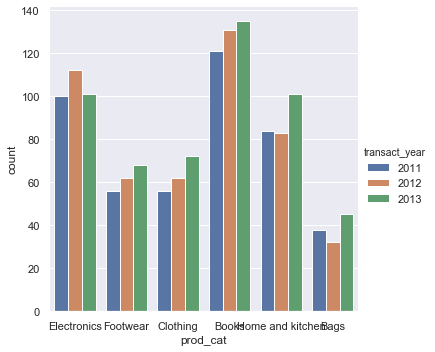

In [46]:
sns.catplot(x='prod_cat', kind='count', hue='transact_year', data=repeat_eshop_df)

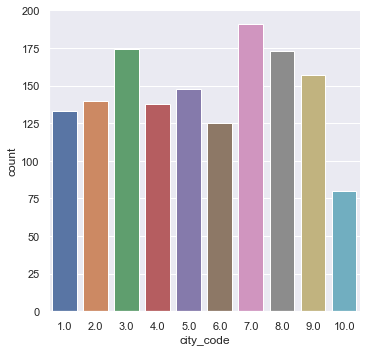

In [47]:
sns.catplot(x='city_code', kind='count', data=repeat_eshop_df)

In [48]:
# exported_dataset_dir = os.path.join(dataset_dir, 'exported')
# if not os.path.exists(exported_dataset_dir):
#     os.mkdir(exported_dataset_dir)
    
# def export_df_to_csv(df, dir, filename):
#     filepath = os.path.join(dir, filename)
#     df.to_csv(filepath, index=False)

# export_df_to_csv(eshop_df, exported_dataset_dir, 'eshop')
    

# After eshop - use emerging markets in clothing, home&kitchen, bags
## Can't for footwear, say that it's hard to shop for footwear since you have to measure and test it out

The graph below shows the sales count of each category from years 2011 to 2013. Categories clothing, home & kitchen and bags are shown to be increasing by year.

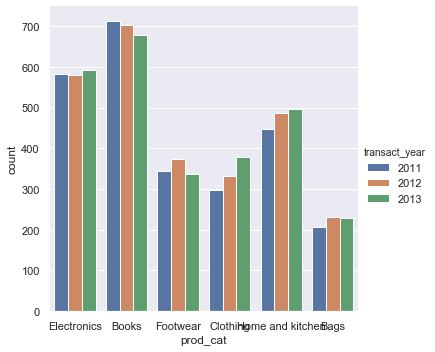

In [49]:
sns.catplot(x='prod_cat', kind='count', hue='transact_year', data=eshop_df)

In [50]:
emerging_categ_df = eshop_df.copy(deep=True)
rows_to_drop = emerging_categ_df[~emerging_categ_df['prod_cat'].isin(['Clothing', 'Home and kitchen', 'Bags'])].index
emerging_categ_df.drop(rows_to_drop, axis=0, inplace=True)
emerging_categ_df.reset_index(drop=True)
emerging_categ_df

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat,age_at_purchase
6,83963970126,274655,2013-12-31 00:00:00.000000,3,1,5,213,111.825,1176.825,e-Shop,2013,12,1981,M,9.0,Clothing,clothing_kids,32
11,51514545410,270709,2013-12-30 00:00:00.000000,1,1,5,1304,684.600,7204.600,e-Shop,2013,12,1976,M,7.0,Clothing,clothing_women,37
13,83941716509,273771,2013-12-30 00:00:00.000000,4,1,5,725,380.625,4005.625,e-Shop,2013,12,1981,M,2.0,Clothing,clothing_mens,32
16,33215457342,272081,2013-12-29 00:00:00.000000,12,6,4,1079,453.180,4769.180,e-Shop,2013,12,1978,F,6.0,Home and kitchen,Tools,35
17,9488888491,267446,2013-12-29 00:00:00.000000,1,4,2,1336,280.560,2952.560,e-Shop,2013,12,1992,M,6.0,Bags,bags_mens,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000,83245680995,273723,2011-01-26 00:00:00.000000,4,4,4,1477,620.340,6528.340,e-Shop,2011,1,1984,F,4.0,Bags,bags_women,27
8003,61812307223,274306,2011-01-25 00:00:00.000000,4,4,4,1447,607.740,6395.740,e-Shop,2011,1,1989,M,2.0,Bags,bags_women,22
8004,39737254095,272286,2011-01-25 00:00:00.000000,2,6,5,71,37.275,392.275,e-Shop,2011,1,1983,M,8.0,Home and kitchen,Furnishing,28
8008,40893803228,272049,2011-01-25 00:00:00.000000,11,6,3,1077,339.255,3570.255,e-Shop,2011,1,1975,F,6.0,Home and kitchen,Bath,36


In [137]:
exported_dataset_dir = os.path.join(dataset_dir, 'exported')
if not os.path.exists(exported_dataset_dir):
    os.mkdir(exported_dataset_dir)
    
def export_df_to_csv(df, dir, filename):
    filepath = os.path.join(dir, filename)
    df.to_csv(filepath, index=False)
    
export_df_to_csv(emerging_categ_df, exported_dataset_dir, 'emerging_categ')

In [51]:
exported_dataset_dir = os.path.join(dataset_dir, 'exported')

tsne_csv = os.path.join(exported_dataset_dir, 'tsne_data')

tsne_df = pd.read_csv(tsne_csv)

In [52]:
tsne_df.describe()

,Unnamed: 0,X,Y,cluster,transaction_id,customer_id
count,3105.000000,3.105000e+03,3.105000e+03,3105.000000,3.105000e+03,3105.000000
mean,1553.000000,-8.421247e-16,-1.830706e-17,5.610628,4.995920e+10,270944.714654
std,896.480619,2.125629e+01,2.351964e+01,2.790716,2.874614e+10,2436.633533
min,1.000000,-4.753769e+01,-5.131336e+01,1.000000,3.268991e+06,266783.000000
25%,777.000000,-1.471717e+01,-1.593102e+01,3.000000,2.545346e+10,268867.000000
50%,1553.000000,4.457233e-01,-2.888481e-01,6.000000,4.907082e+10,270831.000000
75%,2329.000000,1.605700e+01,1.587814e+01,8.000000,7.550590e+10,273083.000000
max,3105.000000,4.321577e+01,4.784209e+01,10.000000,9.987765e+10,275264.000000


In [53]:
cluster_df = lambda query: sqldf(query, globals())
query = """
    SELECT DISTINCT
        e.*,
        t.*
    FROM emerging_categ_df e
    INNER JOIN tsne_df t
        on e.transaction_id = t.transaction_id
"""
cluster_df = cluster_df(query)

In [54]:
cluster_df.describe()

,transaction_id,customer_id,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,transact_year,transact_month,birth_year,city_code,age_at_purchase,Unnamed: 0,X,Y,cluster,transaction_id,customer_id
count,3.105000e+03,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3105.000000,3.105000e+03,3.105000e+03,3105.000000,3.105000e+03,3105.000000
mean,4.995920e+10,270944.714654,5.457971,3.947182,3.016103,779.563285,245.779097,2586.532398,2012.049597,6.664412,1981.083092,5.493398,30.966506,1553.000000,-8.421247e-16,-1.830706e-17,5.610628,4.995920e+10,270944.714654
std,2.874614e+10,2436.633533,4.221202,2.182355,1.415488,418.116580,186.470063,1962.375426,0.811952,3.427466,6.566977,2.850106,6.626702,896.480619,2.125629e+01,2.351964e+01,2.790716,2.874614e+10,2436.633533
min,3.268991e+06,266783.000000,1.000000,1.000000,1.000000,70.000000,7.350000,77.350000,2011.000000,1.000000,1970.000000,1.000000,19.000000,1.000000,-4.753769e+01,-5.131336e+01,1.000000,3.268991e+06,266783.000000
25%,2.545346e+10,268867.000000,2.000000,1.000000,2.000000,413.000000,95.130000,1001.130000,2011.000000,4.000000,1975.000000,3.000000,25.000000,777.000000,-1.471717e+01,-1.593102e+01,3.000000,2.545346e+10,268867.000000
50%,4.907082e+10,270831.000000,4.000000,4.000000,3.000000,777.000000,193.725000,2038.725000,2012.000000,7.000000,1981.000000,5.000000,31.000000,1553.000000,4.457233e-01,-2.888481e-01,6.000000,4.907082e+10,270831.000000
75%,7.550590e+10,273083.000000,10.000000,6.000000,4.000000,1154.000000,364.140000,3832.140000,2013.000000,10.000000,1987.000000,8.000000,37.000000,2329.000000,1.605700e+01,1.587814e+01,8.000000,7.550590e+10,273083.000000
max,9.987765e+10,275264.000000,12.000000,6.000000,5.000000,1500.000000,785.400000,8265.400000,2013.000000,12.000000,1992.000000,10.000000,43.000000,3105.000000,4.321577e+01,4.784209e+01,10.000000,9.987765e+10,275264.000000


In [55]:
print(cluster_df.head())

   transaction_id  customer_id               transact_date  prod_sub_cat_code  \
0     83963970126       274655  2013-12-31 00:00:00.000000                  3   
1     51514545410       270709  2013-12-30 00:00:00.000000                  1   
2     83941716509       273771  2013-12-30 00:00:00.000000                  4   
3     33215457342       272081  2013-12-29 00:00:00.000000                 12   
4      9488888491       267446  2013-12-29 00:00:00.000000                  1   

   prod_cat_code  qty  rate      tax  total_amt store_type  ...  city_code  \
0              1    5   213  111.825   1176.825     e-Shop  ...        9.0   
1              1    5  1304  684.600   7204.600     e-Shop  ...        7.0   
2              1    5   725  380.625   4005.625     e-Shop  ...        2.0   
3              6    4  1079  453.180   4769.180     e-Shop  ...        6.0   
4              4    2  1336  280.560   2952.560     e-Shop  ...        6.0   

           prod_cat    prod_sub_cat age_at_p

In [56]:
cluster_df

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,...,city_code,prod_cat,prod_sub_cat,age_at_purchase,Unnamed: 0,X,Y,cluster,transaction_id,customer_id
0,83963970126,274655,2013-12-31 00:00:00.000000,3,1,5,213,111.825,1176.825,e-Shop,...,9.0,Clothing,clothing_kids,32,1,16.056993,31.849834,1,83963970126,274655
1,51514545410,270709,2013-12-30 00:00:00.000000,1,1,5,1304,684.600,7204.600,e-Shop,...,7.0,Clothing,clothing_women,37,2,-12.186564,35.137528,2,51514545410,270709
2,83941716509,273771,2013-12-30 00:00:00.000000,4,1,5,725,380.625,4005.625,e-Shop,...,2.0,Clothing,clothing_mens,32,3,8.452816,-19.163645,3,83941716509,273771
3,33215457342,272081,2013-12-29 00:00:00.000000,12,6,4,1079,453.180,4769.180,e-Shop,...,6.0,Home and kitchen,Tools,35,4,-21.076777,15.143147,4,33215457342,272081
4,9488888491,267446,2013-12-29 00:00:00.000000,1,4,2,1336,280.560,2952.560,e-Shop,...,6.0,Bags,bags_mens,21,5,-38.411946,15.455088,5,9488888491,267446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,83245680995,273723,2011-01-26 00:00:00.000000,4,4,4,1477,620.340,6528.340,e-Shop,...,4.0,Bags,bags_women,27,3101,18.077423,-29.287769,7,83245680995,273723
3101,61812307223,274306,2011-01-25 00:00:00.000000,4,4,4,1447,607.740,6395.740,e-Shop,...,2.0,Bags,bags_women,22,3102,-1.907253,34.671752,10,61812307223,274306
3102,39737254095,272286,2011-01-25 00:00:00.000000,2,6,5,71,37.275,392.275,e-Shop,...,8.0,Home and kitchen,Furnishing,28,3103,-12.507094,-29.557882,5,39737254095,272286
3103,40893803228,272049,2011-01-25 00:00:00.000000,11,6,3,1077,339.255,3570.255,e-Shop,...,6.0,Home and kitchen,Bath,36,3104,35.048029,-14.840885,8,40893803228,272049


In [57]:
# plt.figure(figsize=(10, 10))

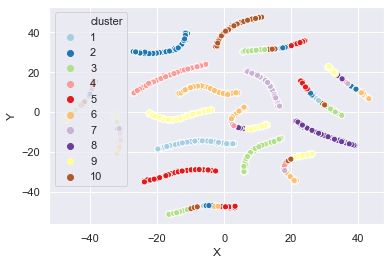

In [58]:
# plt.scatter(cluster_df['X'], cluster_df['Y'], c=cluster_df['cluster'])
# plt.show()
sns.scatterplot(x='X', y='Y', hue='cluster', data=cluster_df, legend='full', palette="Paired")

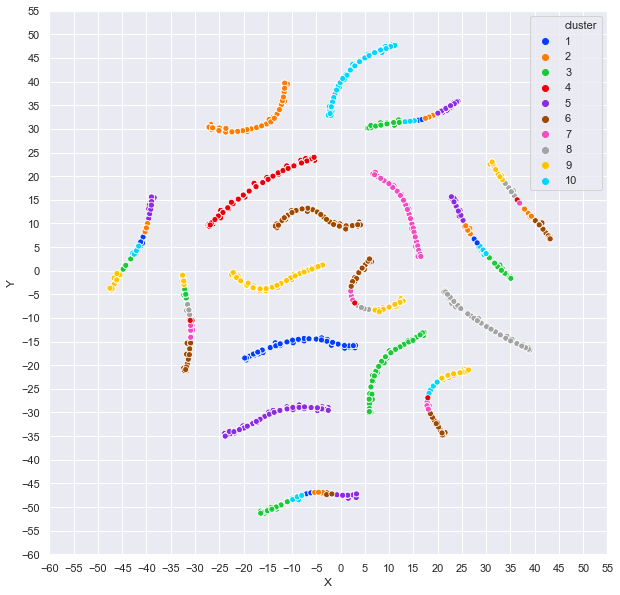

In [87]:
a = sns.scatterplot(x='X', y='Y', hue='cluster', data=cluster_df, legend='full', palette=sns.color_palette(palette='bright'))
a.set_xticks(np.arange(-60,60,5))
a.set_yticks(np.arange(-60,60,5))

# TODO
## 1. Convert city_code, birth_year to categories
## 2. Analyze by half starting at y=0
## 3. Analyze by quadrant

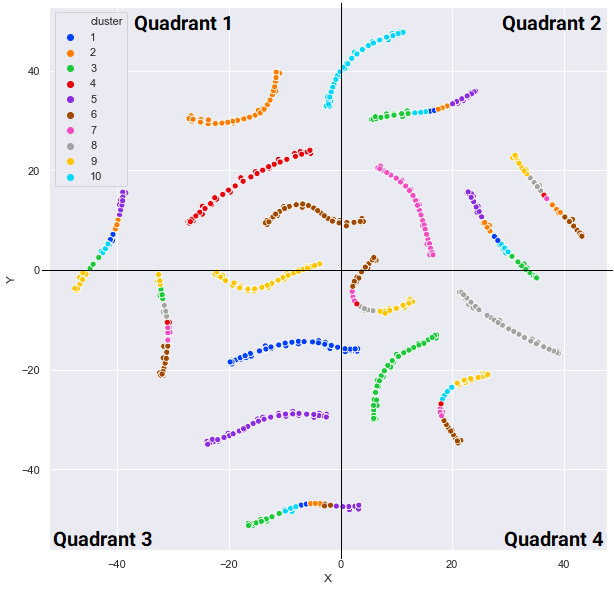

In [60]:
PATH = os.path.join(os.getcwd(), "cluster_python_v5_quadrant.png")
Image(filename=PATH, width=600, height=600)

In [61]:
# Characteristics column
subset_cluster_df = cluster_df[['store_type', 'prod_cat', 'prod_sub_cat', 'city_code', 'birth_year', 'gender', 'X', 'Y', 'cluster']]

In [62]:
cluster_df['prod_sub_cat'].value_counts()

Tools             394
Furnishing        356
clothing_mens     345
Bath              342
Kitchen           338
bags_mens         336
clothing_women    332
bags_women        331
clothing_kids     331
Name: prod_sub_cat, dtype: int64

In [63]:
def describe_all(dataframe)

SyntaxError: invalid syntax (<ipython-input-63-d77c2d1a5d99>, line 1)

In [67]:
# Analyze quadrant 1
quadrant_1 = subset_cluster_df[(cluster_df['X'] < 0) & (cluster_df['Y'] > 0)]
summary = quadrant_1.describe(include='all')
summary = pd.DataFrame(summary)
print(summary)
print(quadrant_1.mode().iloc[0])

       store_type          prod_cat prod_sub_cat   city_code   birth_year  \
count         734               734          734  734.000000   734.000000   
unique          1                 3            5         NaN          NaN   
top        e-Shop  Home and kitchen        Tools         NaN          NaN   
freq          734               332          203         NaN          NaN   
mean          NaN               NaN          NaN    5.523161  1982.464578   
std           NaN               NaN          NaN    2.823384     6.276548   
min           NaN               NaN          NaN    1.000000  1970.000000   
25%           NaN               NaN          NaN    3.000000  1977.250000   
50%           NaN               NaN          NaN    5.000000  1983.000000   
75%           NaN               NaN          NaN    8.000000  1988.000000   
max           NaN               NaN          NaN   10.000000  1992.000000   

       gender           X           Y     cluster  
count     734  734.0000

In [68]:
# Analyze quadrant 2
quadrant_2 = subset_cluster_df[(cluster_df['X'] > 0) & (cluster_df['Y'] > 0)]
summary = quadrant_2.describe(include='all')
print(summary)

       store_type          prod_cat   prod_sub_cat   city_code   birth_year  \
count         813               813            813  813.000000   813.000000   
unique          1                 3              6         NaN          NaN   
top        e-Shop  Home and kitchen  clothing_kids         NaN          NaN   
freq          813               358            195         NaN          NaN   
mean          NaN               NaN            NaN    5.391144  1981.549815   
std           NaN               NaN            NaN    2.815688     6.686803   
min           NaN               NaN            NaN    1.000000  1970.000000   
25%           NaN               NaN            NaN    3.000000  1976.000000   
50%           NaN               NaN            NaN    5.000000  1981.000000   
75%           NaN               NaN            NaN    8.000000  1988.000000   
max           NaN               NaN            NaN   10.000000  1992.000000   

       gender           X           Y     cluster  

In [69]:
# Analyze quadrant 3
quadrant_3 = subset_cluster_df[(cluster_df['X'] < 0) & (cluster_df['Y'] < 0)]
summary = quadrant_3.describe(include='all')
print(summary)

       store_type          prod_cat prod_sub_cat   city_code   birth_year  \
count         808               808          808  808.000000   808.000000   
unique          1                 3            5         NaN          NaN   
top        e-Shop  Home and kitchen   Furnishing         NaN          NaN   
freq          808               472          184         NaN          NaN   
mean          NaN               NaN          NaN    5.389851  1980.137376   
std           NaN               NaN          NaN    2.872809     6.155538   
min           NaN               NaN          NaN    1.000000  1970.000000   
25%           NaN               NaN          NaN    3.000000  1975.000000   
50%           NaN               NaN          NaN    5.000000  1980.000000   
75%           NaN               NaN          NaN    8.000000  1985.000000   
max           NaN               NaN          NaN   10.000000  1992.000000   

       gender           X           Y     cluster  
count     808  808.0000

In [70]:
# Analyze quadrant 4
quadrant_4 = subset_cluster_df[(cluster_df['X'] > 0) & (cluster_df['Y'] < 0)]
summary = quadrant_4.describe(include='all')
print(summary)
print(quadrant_4.mode())

       store_type  prod_cat prod_sub_cat   city_code   birth_year gender  \
count         750       750          750  750.000000   750.000000    750   
unique          1         3            6         NaN          NaN      2   
top        e-Shop  Clothing         Bath         NaN          NaN      F   
freq          750       320          195         NaN          NaN    470   
mean          NaN       NaN          NaN    5.686667  1980.244000    NaN   
std           NaN       NaN          NaN    2.883443     6.862209    NaN   
min           NaN       NaN          NaN    1.000000  1970.000000    NaN   
25%           NaN       NaN          NaN    3.000000  1974.000000    NaN   
50%           NaN       NaN          NaN    6.000000  1980.000000    NaN   
75%           NaN       NaN          NaN    8.000000  1986.750000    NaN   
max           NaN       NaN          NaN   10.000000  1992.000000    NaN   

                 X           Y     cluster  
count   750.000000  750.000000  750.000000


# TODO: Add count for every prod_cat and prod_sub_cat for every quadrant

## BY Cluster

In [ ]:
cluster = 

# Overlapping Clusters

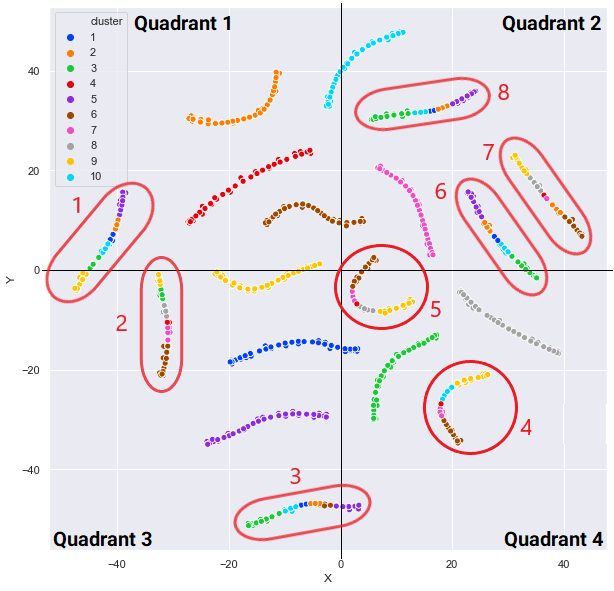

In [71]:
PATH = os.path.join(os.getcwd(), "cluster_python_v5_quadrant_overlap_labelled.png")
Image(filename=PATH, width=600, height=600)

Overlapped Cluster 1 is composed of male customers from city code 3 who buy bags designed for men.

In [72]:
# Overlapped cluster 1 (clusters 1,2,3,5,9,10)
overlap_1 = cluster_df[  (cluster_df['cluster'].isin([1,2,3,5,9,10]))
                       & (cluster_df['X'].between(-60, -37))
                       & (cluster_df['Y'].between(-6, 20))
                      ]
overlap_1.describe(include='all')

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,...,city_code,prod_cat,prod_sub_cat,age_at_purchase,Unnamed: 0,X,Y,cluster,transaction_id,customer_id
count,1.690000e+02,169.000000,169,169.0,169.0,169.000000,169.000000,169.000000,169.000000,169,...,169.000000,169,169,169.000000,169.000000,169.000000,169.000000,169.000000,1.690000e+02,169.000000
unique,NaN,NaN,159,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-08-05 00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,e-Shop,...,NaN,Bags,bags_mens,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,169,...,NaN,169,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.761390e+10,271046.810651,NaN,1.0,4.0,2.928994,827.775148,252.406953,2656.282692,NaN,...,5.349112,NaN,NaN,31.414201,1660.053254,-42.256708,5.610258,5.857988,4.761390e+10,271046.810651
std,2.914888e+10,2479.252415,NaN,0.0,0.0,1.395460,429.459818,187.507132,1973.289341,NaN,...,2.794981,NaN,NaN,6.705100,922.761689,2.946811,6.343812,3.170353,2.914888e+10,2479.252415
min,8.712565e+07,266939.000000,NaN,1.0,4.0,1.000000,78.000000,8.190000,86.190000,NaN,...,1.000000,NaN,NaN,19.000000,5.000000,-47.537689,-4.079728,1.000000,8.712565e+07,266939.000000
25%,2.288016e+10,269080.000000,NaN,1.0,4.0,2.000000,445.000000,109.725000,1154.725000,NaN,...,3.000000,NaN,NaN,25.000000,846.000000,-45.517176,-0.883170,3.000000,2.288016e+10,269080.000000
50%,3.988653e+10,270820.000000,NaN,1.0,4.0,3.000000,837.000000,195.300000,2055.300000,NaN,...,5.000000,NaN,NaN,31.000000,1757.000000,-41.313685,5.208825,5.000000,3.988653e+10,270820.000000
75%,7.316179e+10,273190.000000,NaN,1.0,4.0,4.000000,1239.000000,361.200000,3801.200000,NaN,...,8.000000,NaN,NaN,38.000000,2470.000000,-39.532782,11.061114,9.000000,7.316179e+10,273190.000000


In [73]:
overlap_1.mode()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,...,city_code,prod_cat,prod_sub_cat,age_at_purchase,Unnamed: 0,X,Y,cluster,transaction_id,customer_id
0,87125650,272122.0,2011-08-05 00:00:00.000000,1.0,4.0,3.0,402.0,37.80,397.80,e-Shop,...,3.0,Bags,bags_mens,23.0,5,-47.537689,-4.079728,5.0,87125650,272122.0
1,203539646,273771.0,NaN,NaN,NaN,NaN,479.0,136.08,1432.08,NaN,...,NaN,NaN,NaN,31.0,20,-47.160333,-4.079728,NaN,203539646,273771.0
2,935977226,NaN,NaN,NaN,NaN,NaN,531.0,144.06,1516.06,NaN,...,NaN,NaN,NaN,38.0,31,-47.160333,-4.079728,NaN,935977226,NaN
3,1853454901,NaN,NaN,NaN,NaN,NaN,840.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,45,-47.160333,-4.079728,NaN,1853454901,NaN
4,2479627169,NaN,NaN,NaN,NaN,NaN,1280.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,55,-47.160333,-4.079727,NaN,2479627169,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,97095291921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3042,-38.951159,15.600648,NaN,97095291921,NaN
165,98442163389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3067,-38.950550,15.600648,NaN,98442163389,NaN
166,98692222332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3071,-38.908099,15.600648,NaN,98692222332,NaN
167,99306104612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3075,-38.908098,15.600648,NaN,99306104612,NaN


Overlapped Cluster 2 is composed of Female customers from city code 5. They bought clothes designed for men.

In [92]:
overlap_2 = cluster_df[  (cluster_df['cluster'].isin([3,4,6,7,8,9]))
                       & (cluster_df['X'].between(-35, -30))
                       & (cluster_df['Y'].between(-23, 1))
                      ]
overlap_2.describe(include='all')


,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,...,city_code,prod_cat,prod_sub_cat,age_at_purchase,Unnamed: 0,X,Y,cluster,transaction_id,customer_id
count,1.610000e+02,161.000000,161,161.0,161.0,161.000000,161.000000,161.000000,161.000000,161,...,161.000000,161,161,161.000000,161.000000,161.000000,161.000000,161.000000,1.610000e+02,161.000000
unique,NaN,NaN,146,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-07-15 00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,e-Shop,...,NaN,Clothing,clothing_mens,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,161,...,NaN,161,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.129784e+10,271031.720497,NaN,4.0,1.0,3.062112,819.459627,266.688261,2806.576460,NaN,...,5.428571,NaN,NaN,30.490683,1587.043478,-31.546997,-11.253798,6.416149,5.129784e+10,271031.720497
std,2.849211e+10,2385.619265,NaN,0.0,0.0,1.426050,439.409917,203.578811,2142.424627,NaN,...,2.823372,NaN,NaN,6.130985,919.141946,0.577691,6.522672,1.859298,2.849211e+10,2385.619265
min,2.143613e+09,266806.000000,NaN,4.0,1.0,1.000000,100.000000,10.500000,110.500000,NaN,...,1.000000,NaN,NaN,19.000000,6.000000,-32.701486,-21.204811,3.000000,2.143613e+09,266806.000000
25%,2.757820e+10,269178.000000,NaN,4.0,1.0,2.000000,402.000000,96.705000,1017.705000,NaN,...,3.000000,NaN,NaN,26.000000,802.000000,-31.923576,-17.665160,6.000000,2.757820e+10,269178.000000
50%,5.376838e+10,271091.000000,NaN,4.0,1.0,3.000000,859.000000,223.020000,2347.020000,NaN,...,5.000000,NaN,NaN,30.000000,1567.000000,-31.383441,-11.593465,6.000000,5.376838e+10,271091.000000
75%,7.720168e+10,272878.000000,NaN,4.0,1.0,4.000000,1206.000000,380.520000,4004.520000,NaN,...,8.000000,NaN,NaN,35.000000,2418.000000,-30.989307,-4.991551,8.000000,7.720168e+10,272878.000000


In [91]:
overlap_2.mode().iloc[0]

transaction_id                       2143612647
customer_id                              273503
transact_date        2011-04-17 00:00:00.000000
prod_sub_cat_code                             4
prod_cat_code                                 1
qty                                           4
rate                                        117
tax                                       26.46
total_amt                                278.46
store_type                               e-Shop
transact_year                              2012
transact_month                               12
birth_year                                 1985
gender                                        F
city_code                                     5
prod_cat                               Clothing
prod_sub_cat                      clothing_mens
age_at_purchase                              38
Unnamed: 0                                    6
X                                      -32.5683
Y                                      -

Overlapped Cluster 3 is composed of men who purchase kitchen products

In [93]:
overlap_3 = subset_cluster_df[  (subset_cluster_df['cluster'].isin([1,2,3,5,6,10]))
                              & (subset_cluster_df['X'].between(-20, 5))
                              & (subset_cluster_df['Y'].between(-55, -45))
                             ]
overlap_3.describe(include='all')

,store_type,prod_cat,prod_sub_cat,city_code,birth_year,gender,X,Y,cluster
count,170,170,170,170.000000,170.000000,170,170.000000,170.000000,170.000000
unique,1,1,1,NaN,NaN,1,NaN,NaN,NaN
top,e-Shop,Home and kitchen,Kitchen,NaN,NaN,M,NaN,NaN,NaN
freq,170,170,170,NaN,NaN,170,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.364706,1981.741176,NaN,-6.508950,-48.315736,4.788235
std,NaN,NaN,NaN,2.932564,6.757250,NaN,6.379654,1.461260,2.720051
min,NaN,NaN,NaN,1.000000,1970.000000,NaN,-16.507949,-51.313356,1.000000
25%,NaN,NaN,NaN,3.000000,1976.000000,NaN,-12.276018,-49.547901,3.000000
50%,NaN,NaN,NaN,5.000000,1981.500000,NaN,-6.582419,-47.514633,5.000000
75%,NaN,NaN,NaN,8.000000,1988.000000,NaN,-0.754457,-47.222926,6.000000


In [94]:
overlap_3.mode().iloc[0]

store_type                e-Shop
prod_cat        Home and kitchen
prod_sub_cat             Kitchen
city_code                      8
birth_year                  1979
gender                         M
X                       -1.79671
Y                       -47.2331
cluster                        3
Name: 0, dtype: object

Overlapped Cluster 4 is composed of women who buys bags designed for women.

In [95]:
overlap_4 = subset_cluster_df[  (subset_cluster_df['cluster'].isin([4,6,7,9,10]))
                              & (subset_cluster_df['X'].between(15, 30))
                              & (subset_cluster_df['Y'].between(-40, -20))
                             ]
overlap_4.describe(include='all')

,store_type,prod_cat,prod_sub_cat,city_code,birth_year,gender,X,Y,cluster
count,162,162,162,162.000000,162.000000,162,162.000000,162.000000,162.000000
unique,1,1,1,NaN,NaN,1,NaN,NaN,NaN
top,e-Shop,Bags,bags_women,NaN,NaN,F,NaN,NaN,NaN
freq,162,162,162,NaN,NaN,162,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.759259,1980.796296,NaN,20.757858,-26.936156,7.820988
std,NaN,NaN,NaN,2.816997,6.670729,NaN,2.558239,4.757777,1.689957
min,NaN,NaN,NaN,1.000000,1970.000000,NaN,17.814179,-34.755976,4.000000
25%,NaN,NaN,NaN,4.000000,1975.000000,NaN,18.578681,-31.649690,6.000000
50%,NaN,NaN,NaN,6.000000,1980.000000,NaN,20.183856,-25.967525,9.000000
75%,NaN,NaN,NaN,8.000000,1987.000000,NaN,22.127951,-22.128806,9.000000


In [96]:
overlap_4.mode().iloc[0]

store_type          e-Shop
prod_cat              Bags
prod_sub_cat    bags_women
city_code                5
birth_year            1972
gender                   F
X                  19.1168
Y                 -24.4098
cluster                  9
Name: 0, dtype: object

Overlapped Cluster 5 is composed of women who buy children's clothes.

In [97]:
overlap_5 = subset_cluster_df[  (subset_cluster_df['cluster'].isin([4,6,7,8,9]))
                              & (subset_cluster_df['X'].between(0, 15))
                              & (subset_cluster_df['Y'].between(-10, 5))
                             ]
overlap_5.describe(include='all')

,store_type,prod_cat,prod_sub_cat,city_code,birth_year,gender,X,Y,cluster
count,172,172,172,172.000000,172.00000,172,172.000000,172.000000,172.000000
unique,1,1,1,NaN,NaN,1,NaN,NaN,NaN
top,e-Shop,Clothing,clothing_kids,NaN,NaN,F,NaN,NaN,NaN
freq,172,172,172,NaN,NaN,172,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.482558,1980.94186,NaN,6.113912,-4.398737,7.290698
std,NaN,NaN,NaN,2.978429,7.19219,NaN,3.502201,3.740023,1.501393
min,NaN,NaN,NaN,1.000000,1970.00000,NaN,2.085819,-8.704551,4.000000
25%,NaN,NaN,NaN,3.000000,1974.00000,NaN,2.923369,-7.710074,6.000000
50%,NaN,NaN,NaN,5.500000,1981.00000,NaN,5.097155,-6.308584,7.000000
75%,NaN,NaN,NaN,8.000000,1987.00000,NaN,8.812209,-1.451402,9.000000


In [98]:
overlap_5.mode().iloc[0]

store_type             e-Shop
prod_cat             Clothing
prod_sub_cat    clothing_kids
city_code                   9
birth_year               1970
gender                      F
X                     11.1957
Y                     -1.4514
cluster                     6
Name: 0, dtype: object

Overlapped Cluster 6 is composed of males who buy bath products

In [99]:
overlap_6 = subset_cluster_df[  (subset_cluster_df['cluster'].isin([1,2,3,5,10]))
                              & (subset_cluster_df['X'].between(20, 38))
                              & (subset_cluster_df['Y'].between(-5, 18))
                             ]
overlap_6.describe(include='all')

,store_type,prod_cat,prod_sub_cat,city_code,birth_year,gender,X,Y,cluster
count,172,172,172,172.000000,172.000000,172,172.000000,172.000000,172.000000
unique,1,2,2,NaN,NaN,2,NaN,NaN,NaN
top,e-Shop,Home and kitchen,Bath,NaN,NaN,M,NaN,NaN,NaN
freq,172,170,170,NaN,NaN,170,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.395349,1981.348837,NaN,28.435485,6.685044,4.470930
std,NaN,NaN,NaN,2.823374,6.454098,NaN,4.052302,5.596234,2.689436
min,NaN,NaN,NaN,1.000000,1970.000000,NaN,22.650948,-1.646770,1.000000
25%,NaN,NaN,NaN,3.000000,1975.000000,NaN,24.796428,1.101426,3.000000
50%,NaN,NaN,NaN,5.000000,1981.000000,NaN,28.146801,5.889465,3.000000
75%,NaN,NaN,NaN,8.000000,1987.000000,NaN,32.389228,11.715686,5.000000


In [100]:
overlap_6.mode().iloc[0]

store_type                e-Shop
prod_cat        Home and kitchen
prod_sub_cat                Bath
city_code                      3
birth_year                  1975
gender                         M
X                        22.6509
Y                       -1.64677
cluster                        5
Name: 0, dtype: object

Overlapped Cluster 7 is composed of women who buy women's clothes.

In [101]:
overlap_7 = subset_cluster_df[  (subset_cluster_df['cluster'].isin([2,4,6,7,8,9]))
                              & (subset_cluster_df['X'].between(30, 45))
                              & (subset_cluster_df['Y'].between(5, 25))
                             ]
overlap_7.describe(include='all')

,store_type,prod_cat,prod_sub_cat,city_code,birth_year,gender,X,Y,cluster
count,155,155,155,155.000000,155.000000,155,155.000000,155.000000,155.000000
unique,1,1,1,NaN,NaN,1,NaN,NaN,NaN
top,e-Shop,Clothing,clothing_women,NaN,NaN,F,NaN,NaN,NaN
freq,155,155,155,NaN,NaN,155,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.606452,1980.974194,NaN,36.892649,14.820880,6.741935
std,NaN,NaN,NaN,2.852424,6.557387,NaN,4.040908,5.292273,2.194559
min,NaN,NaN,NaN,1.000000,1970.000000,NaN,30.794380,6.733966,2.000000
25%,NaN,NaN,NaN,3.000000,1975.000000,NaN,33.020802,9.695763,6.000000
50%,NaN,NaN,NaN,5.000000,1981.000000,NaN,36.406881,14.986432,7.000000
75%,NaN,NaN,NaN,8.000000,1987.000000,NaN,40.941723,19.859272,9.000000


In [102]:
overlap_7.mode().iloc[0]

store_type              e-Shop
prod_cat              Clothing
prod_sub_cat    clothing_women
city_code                    7
birth_year                1987
gender                       F
X                      39.3272
Y                      6.73397
cluster                      6
Name: 0, dtype: object

Overlapped Cluster 8 is composed of males who buy children's clothes

In [103]:
overlap_8 = subset_cluster_df[  (subset_cluster_df['cluster'].isin([1,2,3,5,10]))
                              & (subset_cluster_df['X'].between(4, 26))
                              & (subset_cluster_df['Y'].between(28, 39))
                             ]
overlap_8.describe(include='all')

,store_type,prod_cat,prod_sub_cat,city_code,birth_year,gender,X,Y,cluster
count,159,159,159,159.000000,159.000000,159,159.000000,159.000000,159.000000
unique,1,1,1,NaN,NaN,1,NaN,NaN,NaN
top,e-Shop,Clothing,clothing_kids,NaN,NaN,M,NaN,NaN,NaN
freq,159,159,159,NaN,NaN,159,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.345912,1980.723270,NaN,15.081905,32.367527,4.044025
std,NaN,NaN,NaN,2.821678,6.557354,NaN,6.052602,1.718016,2.298447
min,NaN,NaN,NaN,1.000000,1970.000000,NaN,5.500795,30.159673,1.000000
25%,NaN,NaN,NaN,3.000000,1975.000000,NaN,9.565246,31.041022,3.000000
50%,NaN,NaN,NaN,5.000000,1980.000000,NaN,15.191172,31.720921,3.000000
75%,NaN,NaN,NaN,8.000000,1987.000000,NaN,20.794137,33.775849,5.000000


In [104]:
overlap_8.mode().iloc[0]

store_type             e-Shop
prod_cat             Clothing
prod_sub_cat    clothing_kids
city_code                   5
birth_year               1976
gender                      M
X                      5.5008
Y                     30.1597
cluster                     3
Name: 0, dtype: object

# ---------------------------------------------

In [ ]:
# Overlapping clusters 8 and 10 on y > 0 (y half 2) #TODO can be by quadrant since there is an x-axis too
ol_8_and_10_yh2 = cluster_df[(cluster_df['cluster'].isin([8, 10])) & (cluster_df['X'] < 20) & (cluster_df['X'] > 0) & (cluster_df['Y'] < 20)]
# ol_8_and_10_yh2 = overlap_8_and_10[['store_type', 'prod_cat', 'prod_sub_cat', 'city_code', 'birth_year', 'gender']]
ol_8_and_10_yh2.describe(include="all")

In [ ]:
# Overlapping clusters 8 and 10 on y > 0 (y half 2) #TODO can be by quadrant since there is an x-axis too
ol_8_and_10_q1 = cluster_df[(cluster_df['cluster'].isin([8, 10])) & (cluster_df['X'] < -20) & (cluster_df['Y'] < 20)]
ol_8_and_10_q1 = ol_8_and_10_q1[['store_type', 'prod_cat', 'prod_sub_cat', 'city_code', 'birth_year', 'gender']]
ol_8_and_10_q1.describe(include="all")

# After eshop - use emerging markets in clothing, home&kitchen, bags
## Can't for footwear, say that it's hard to shop for footwear since you have to measure and test it out